In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

#from AI.Features.Segmenting import deep_segment
#from AI.Features.SegmentingV2 import deep_segment
#from AI.Features.SegmentingV8 import deep_segment

#from AI.Features.Segmenting import restore_mask
#from AI.Features.SegmentingV8 import restore_mask

from skimage import measure
import glob
import pandas as pd 

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn import metrics
from sklearn.metrics import accuracy_score,f1_score
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
from skimage import feature
import os

In [2]:
################################ Augmentation Function ##################################

def augm(lst, nm=5):
    # prepare iterator
    ls_gen=[]
    for arr in lst:
        data = arr
        # expand dimension to one sample
        samples = expand_dims(data, 0)
        # create image data augmentation generator
        datagen = ImageDataGenerator(zoom_range=[0.5,1.0],
                                     brightness_range=[0.8,1],
                                     #rotation_range=50,
                                     width_shift_range=[0,.1],
                                     height_shift_range=[0,.1],
                                    #vertical_flip =True,
                                    #horizontal_flip=True
                                    ) 
        it = datagen.flow(samples, batch_size=1)
        # generate samples and plot

        for i in range(nm):
            # define subplot
            #pyplot.subplot(330 + 1 + i)
            # generate batch of images
            batch = it.next()
            # convert to unsigned integers for viewing
            image = batch[0].astype('uint8')
            ls_gen.append(image)
    return lst+ls_gen

In [3]:
def get_nuc_and_cyt(segmented):
    nuc = (segmented==2).astype('uint8')
    cyt = (segmented==1).astype('uint8')
    #cyt,nuc=restore_mask(segmented)
    return cyt,nuc
     
def mask_cell(img):
    im_mask=deep_segment(img)
    #print(im_mask.sum())
    #if im_mask.sum()<1000:
    #    print("No Cell detected")
    #    return img
    cyt,nuc= get_nuc_and_cyt(im_mask)
    if nuc.sum()!=0:
        #reg=measure.regionprops(cyt)
        tb=measure.regionprops(nuc)[0]['bbox']
    else:
        print("No cell detected...........")
        tb=(0,0,img.shape[0]-1,img.shape[1]-1)
    #img=cv2.blur(img,(3,3))                #++
    #img=cv2.medianBlur(img,15)
     
    im=img.copy()
    rows=im_mask.shape[0]
    columns=im_mask.shape[1]
    for i in range(rows):
        for j in range(columns):
            if im_mask[i,j]==0:
                im[i,j,:]=0
    im=im[tb[0]:tb[2],tb[1]:tb[3]]  #to crop it around box
    #im=cv2.resize(im,(100,100))
    return im


In [4]:
######################################### Deep Feature Extractor #################################


import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import time
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib
import cv2

# Load model into KerasLayer
#model_url = "https://tfhub.dev/google/bit/m-r50x1/1"
#model_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_s/feature_vector/2" #.99
#model_url = "https://tfhub.dev/google/imagenet/resnet_v2_152/feature_vector/5"          #97
model_url = ".\imagenet_efficientnet_v2_imagenet21k_s_feature_vector_2"
module = hub.KerasLayer(model_url)

def deepfeature(image):
    image = np.array(image)
    if len(image.shape)==2:
        backtorgb = cv2.cvtColor(np.array(image, dtype=np.uint8),cv2.COLOR_GRAY2RGB)
        image=backtorgb
    image=cv2.resize(image,(384,384))
    # reshape into shape [batch_size, height, width, num_channels]
    img_reshaped = tf.reshape(image, [1, image.shape[0], image.shape[1], image.shape[2]])
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    image = tf.image.convert_image_dtype(img_reshaped, tf.float32)
    logits=module(image)
    return np.array(logits)[0]


In [5]:

def features(c, f):
    if f==1:
        return all_together(c) 
    elif f==2:
        return obj.describe(mask_cell(c))
    elif f==3:
        return LBP_and_extent(c)
    elif f==4:
        return vggface3(c)
    elif f==5:
        return SOE_and_extent(c)
    elif f==6:
        return SOE_LBP_and_extent(c)
    elif f==7:
        return deepfeature(c)
    elif f==8:
        return SOE(c)
    elif f==9:
        return shape_features(c)
    elif f==10:
        return shapef_and_SOE(c)    
    elif f==11:
        return shapef_and_SOE_extent(c)    
    elif f==12:
        return shapef_and_SOE_extent_LBP(c)  
    elif f==13:
        return shapef_extent(c)  
    elif f==14:
        return GLCM(mask_cell(c))
    elif f==15:
        return shapef_GLCM(c)
    elif f==16:
        return shapef_GLCM_SOE(c)  
    elif f==17:
        return HOG_im(c)[0]    
    elif f==18:
        return shapef_GLCM_SOE_HOG(c)
    elif f==19:
        #PCA
        c=cv2.resize(mask_cell(c),(100,100))
        return c.reshape(-1)  
    elif f==20:
        #lda
        c=cv2.resize(mask_cell(c),(100,100))
        return c.reshape(-1)

In [6]:

def alldata(cls,ft):

    if cls==2:
        lymph_extent = [ features(c, ft) for c in lymph]
        neut_extent = [features(c, ft) for c in neut]
        x = np.array(lymph_extent + neut_extent)#
        if ft==1: x=x.reshape(-1, 1)
        y = len(lymph_extent)*[0] + len(neut_extent)*[1]

    
    elif cls==3:
        neut_extent = [features(c, ft) for c in neut]
        lymph_extent = [features(c, ft) for c in lymph]
        MONO_extent = [ features(c, ft)  for c  in MONO]
        x = np.array(lymph_extent + neut_extent+ MONO_extent)#.reshape(-1, 1)
        if ft==1: x=x.reshape(-1, 1)
        y = len(lymph_extent)*[0] + len(neut_extent)*[1]+len(MONO_extent)*[2]
        
    elif cls==5:
        neut_extent = [features(c, ft)  for c  in neut]
        lymph_extent = [features(c, ft)  for c  in lymph]
        BASO_extent = [ features(c, ft)  for c  in BASO]
        EOSI_extent = [ features(c, ft)  for c in EOSI]
        MONO_extent = [ features(c, ft)  for c  in MONO]
        x = np.array(lymph_extent + neut_extent+ BASO_extent+ EOSI_extent+ MONO_extent)#.reshape(-1, 1)
        if ft==1: x=x.reshape(-1, 1)
        y = len(lymph_extent)*[0] + len(neut_extent)*[1]+len(BASO_extent)*[2]+len(EOSI_extent)*[3]+len(MONO_extent)*[4]
        
    return x,y

In [52]:
############################ PBC ##################################################

lymph = [cv2.imread(f)[:,:,::-1] for f in glob.glob('./samples/PBC/LYMPH/*.jpg')]
neut =  [cv2.imread(f)[:,:,::-1] for f in glob.glob('./samples/PBC/NEUT/*.jpg')]
BASO =  [cv2.imread(f)[:,:,::-1] for f in glob.glob('./samples/PBC/BASO/*.jpg')]
EOSI =  [cv2.imread(f)[:,:,::-1] for f in glob.glob('./samples/PBC/EOSI/*.jpg')]
MONO =  [cv2.imread(f)[:,:,::-1] for f in glob.glob('./samples/PBC/MONO/*.jpg')]

In [ ]:
# BCCD Dataset The labels (1- 5) represent neutrophil, lymphocyte, monocyte, eosinophil and basophil, respectively.

data1 = [cv2.imread(f)[:,:,::-1] for f in glob.glob('./samples/BCCD/Dataset1/*.bmp')]
data2 = [cv2.imread(f)[:,:,::-1] for f in glob.glob('./samples/BCCD/Dataset2/*.bmp')]


labels1 = pd.read_csv("./samples/BCCD/Class Labels of Dataset 1.csv") 
lst1=labels1['class label'].tolist()

labels2 = pd.read_csv("./samples/BCCD/Class Labels of Dataset 2.csv") 
lst2=labels2['class'].tolist()

ims=data1#data2+data1
lst=lst1# lst2+lst1

neut = [ims[i] for i,c in enumerate(lst) if c==1] #+neut
lymph = [ims[i] for i,c in enumerate(lst) if c==2] #+lymph
MONO =  [ims[i] for i,c in enumerate(lst) if c==3] #+MONO
EOSI = [ims[i] for i,c in enumerate(lst) if c==4] #+EOSI 
BASO =  [ims[i] for i,c in enumerate(lst) if c==5] #+BASO

In [ ]:
####################### Load Traing Images ###################################################

path1='./samples/Animals/goat/*/'      
lymph = [cv2.imread(f)[:,:,::-1] for f in glob.glob(path1+'Lymphocyte/*.png') if os.path.getsize(f)>200]
neut =  [cv2.imread(f)[:,:,::-1] for f in glob.glob(path1+'Neutrophil/*.png') if os.path.getsize(f)>200]
BASO =  [cv2.imread(f)[:,:,::-1] for f in glob.glob(path1+'Basophil/*.png') if os.path.getsize(f)>200]
EOSI =  [cv2.imread(f)[:,:,::-1] for f in glob.glob(path1+'Eosinophil/*.png') if os.path.getsize(f)>200]
MONO =  [cv2.imread(f)[:,:,::-1] for f in glob.glob(path1+'Monocyte/*.png')if os.path.getsize(f)>200]

#GAN
#path2='./samples/Monocyte_images/'
#MONO_GAN=[cv2.imread(f)[:,:,::-1] for f in glob.glob(path2+'Monocyte/*.jpg')if os.path.getsize(f)>200]
#MONO=MONO+MONO_GAN


#path3='./samples/Animals/horse/*/'    
#MONO_horse =  [cv2.imread(f)[:,:,::-1] for f in glob.glob(path3+'Monocyte/*.png')if os.path.getsize(f)>200]
#MONO=MONO+MONO_horse

 

#MONO=augm(MONO, nm=3)
#lymph=lymph[2000:]


lymph= 40
neut= 60
MONO= 60
BASO= 30
EOSI= 30
[40, 60, 60, 30, 30]
220


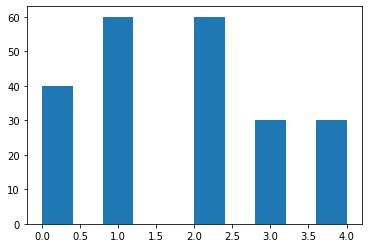

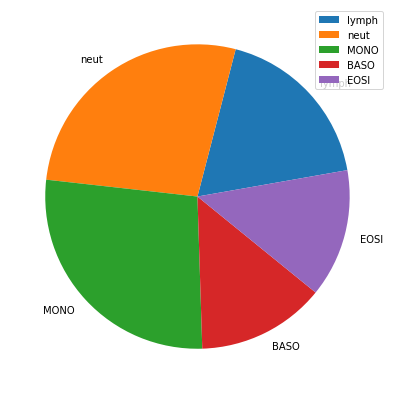

In [53]:

ln=[len(lymph),len(neut),len(MONO),len(BASO),len(EOSI)]
print('lymph=',len(lymph))
print('neut=',len(neut))
print('MONO=',len(MONO))
print('BASO=',len(BASO))
print('EOSI=',len(EOSI))

print(ln)
print(sum(ln))
ls5=len(lymph)*[0] + len(neut)*[1]+len(MONO)*[2]+len(BASO)*[3]+len(EOSI)*[4]
p=plt.hist(ls5,10)
plt.show()

y = np.array(ln)
mylabels =["lymph","neut","MONO","BASO","EOSI"] 
plt.figure(figsize=(7, 7))
plt.pie(y, labels = mylabels, startangle = 10)
plt.legend()
plt.show()


In [54]:
############################ Extract The Deep Features from Training Set #######################

cl=5    # The number of cell types 2,3 or 5
fe=7    # The type of the features extractor
x,y=alldata(cl,fe)

In [95]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.15)

In [96]:
dic={0:[1,0,0,0,0],1:[0,1,0,0,0],2:[0,0,1,0,0],3:[0,0,0,1,0],4:[0,0,0,0,1]}
y_train=np.array([dic[x]  for x in y_train] )

dic={0:[1,0,0,0,0],1:[0,1,0,0,0],2:[0,0,1,0,0],3:[0,0,0,1,0],4:[0,0,0,0,1]}
y_test=np.array([dic[x]  for x in y_test] )

In [101]:
#################################### Deep Front end classification ##################################

class_weight = {0: 1,1: 1,2: 1,3:1, 4:1}

from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from keras.optimizers import Adam
from keras.optimizers import SGD

model = Sequential()
model.add(Dense(100, input_dim=X_train.shape[1], activation = 'relu'))
model.add(Dropout(0.3))
#model.add(Dense(50, activation = 'relu'))
#model.add(Dropout(0.2))
model.add(Dense(10, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(5, activation = 'softmax'))


#sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile('sgd',loss='categorical_crossentropy',metrics=['accuracy'])

model.fit(X_train, y_train, epochs=300, batch_size=16,  validation_data = (X_test, y_test),class_weight=class_weight)

Epoch 1/300
12/12 [==============================] - 2s 62ms/step - loss: 1.8680 - accuracy: 0.2203 - val_loss: 1.5950 - val_accuracy: 0.2424
Epoch 2/300
12/12 [==============================] - 0s 13ms/step - loss: 1.5701 - accuracy: 0.3583 - val_loss: 1.3435 - val_accuracy: 0.5455
Epoch 3/300
12/12 [==============================] - 0s 14ms/step - loss: 1.4429 - accuracy: 0.3037 - val_loss: 1.4113 - val_accuracy: 0.4242
Epoch 4/300
12/12 [==============================] - 0s 12ms/step - loss: 1.4617 - accuracy: 0.3437 - val_loss: 1.3448 - val_accuracy: 0.4242
Epoch 5/300
12/12 [==============================] - 0s 14ms/step - loss: 1.3157 - accuracy: 0.4375 - val_loss: 1.1096 - val_accuracy: 0.5758
Epoch 6/300
12/12 [==============================] - 0s 11ms/step - loss: 1.2588 - accuracy: 0.4007 - val_loss: 1.1022 - val_accuracy: 0.6667
Epoch 7/300
12/12 [==============================] - 0s 12ms/step - loss: 1.3004 - accuracy: 0.4078 - val_loss: 1.0111 - val_accuracy: 0.7879
Epoch 

12/12 [==============================] - 0s 14ms/step - loss: 0.2700 - accuracy: 0.9111 - val_loss: 0.3516 - val_accuracy: 0.8485
Epoch 59/300
12/12 [==============================] - 0s 15ms/step - loss: 0.3667 - accuracy: 0.8566 - val_loss: 0.2581 - val_accuracy: 0.9091
Epoch 60/300
12/12 [==============================] - 0s 11ms/step - loss: 0.4550 - accuracy: 0.8198 - val_loss: 0.2911 - val_accuracy: 0.9394
Epoch 61/300
12/12 [==============================] - 0s 11ms/step - loss: 0.3725 - accuracy: 0.8840 - val_loss: 0.2526 - val_accuracy: 0.9394
Epoch 62/300
12/12 [==============================] - 0s 11ms/step - loss: 0.4639 - accuracy: 0.8148 - val_loss: 0.2132 - val_accuracy: 0.9394
Epoch 63/300
12/12 [==============================] - 0s 11ms/step - loss: 0.3990 - accuracy: 0.8513 - val_loss: 0.3673 - val_accuracy: 0.8485
Epoch 64/300
12/12 [==============================] - 0s 14ms/step - loss: 0.3420 - accuracy: 0.9021 - val_loss: 0.3269 - val_accuracy: 0.9091
Epoch 65/300

12/12 [==============================] - 0s 12ms/step - loss: 0.3038 - accuracy: 0.8986 - val_loss: 0.2859 - val_accuracy: 0.8788
Epoch 116/300
12/12 [==============================] - 0s 14ms/step - loss: 0.1700 - accuracy: 0.9285 - val_loss: 0.2172 - val_accuracy: 0.9394
Epoch 117/300
12/12 [==============================] - 0s 14ms/step - loss: 0.1828 - accuracy: 0.9440 - val_loss: 0.2963 - val_accuracy: 0.8788
Epoch 118/300
12/12 [==============================] - 0s 14ms/step - loss: 0.2339 - accuracy: 0.8972 - val_loss: 0.1951 - val_accuracy: 0.9394
Epoch 119/300
12/12 [==============================] - 0s 14ms/step - loss: 0.1478 - accuracy: 0.9586 - val_loss: 0.2714 - val_accuracy: 0.9394
Epoch 120/300
12/12 [==============================] - 0s 12ms/step - loss: 0.2291 - accuracy: 0.9007 - val_loss: 0.3123 - val_accuracy: 0.9091
Epoch 121/300
12/12 [==============================] - 0s 14ms/step - loss: 0.2126 - accuracy: 0.9348 - val_loss: 0.1953 - val_accuracy: 0.9394
Epoch 

Epoch 172/300
12/12 [==============================] - 0s 15ms/step - loss: 0.1196 - accuracy: 0.9597 - val_loss: 0.2822 - val_accuracy: 0.9394
Epoch 173/300
12/12 [==============================] - 0s 11ms/step - loss: 0.2049 - accuracy: 0.8998 - val_loss: 0.2205 - val_accuracy: 0.9394
Epoch 174/300
12/12 [==============================] - 0s 13ms/step - loss: 0.2167 - accuracy: 0.9024 - val_loss: 0.2649 - val_accuracy: 0.9091
Epoch 175/300
12/12 [==============================] - 0s 13ms/step - loss: 0.1971 - accuracy: 0.8928 - val_loss: 0.2577 - val_accuracy: 0.9091
Epoch 176/300
12/12 [==============================] - 0s 12ms/step - loss: 0.1780 - accuracy: 0.9123 - val_loss: 0.2331 - val_accuracy: 0.9091
Epoch 177/300
12/12 [==============================] - 0s 12ms/step - loss: 0.2304 - accuracy: 0.8965 - val_loss: 0.3025 - val_accuracy: 0.9091
Epoch 178/300
12/12 [==============================] - 0s 11ms/step - loss: 0.1710 - accuracy: 0.9341 - val_loss: 0.3243 - val_accuracy:

Epoch 229/300
12/12 [==============================] - 0s 12ms/step - loss: 0.1745 - accuracy: 0.9130 - val_loss: 0.3545 - val_accuracy: 0.9091
Epoch 230/300
12/12 [==============================] - 0s 11ms/step - loss: 0.1374 - accuracy: 0.9508 - val_loss: 0.2669 - val_accuracy: 0.9394
Epoch 231/300
12/12 [==============================] - 0s 10ms/step - loss: 0.1505 - accuracy: 0.9291 - val_loss: 0.2605 - val_accuracy: 0.9394
Epoch 232/300
12/12 [==============================] - 0s 11ms/step - loss: 0.1880 - accuracy: 0.8885 - val_loss: 0.1504 - val_accuracy: 0.9697
Epoch 233/300
12/12 [==============================] - 0s 11ms/step - loss: 0.1098 - accuracy: 0.9505 - val_loss: 0.1916 - val_accuracy: 0.9394
Epoch 234/300
12/12 [==============================] - 0s 12ms/step - loss: 0.1259 - accuracy: 0.9509 - val_loss: 0.3446 - val_accuracy: 0.9091
Epoch 235/300
12/12 [==============================] - 0s 11ms/step - loss: 0.1156 - accuracy: 0.9367 - val_loss: 0.3849 - val_accuracy:

Epoch 286/300
12/12 [==============================] - 0s 17ms/step - loss: 0.1291 - accuracy: 0.9542 - val_loss: 0.3010 - val_accuracy: 0.9091
Epoch 287/300
12/12 [==============================] - 0s 13ms/step - loss: 0.1857 - accuracy: 0.9394 - val_loss: 0.2329 - val_accuracy: 0.9394
Epoch 288/300
12/12 [==============================] - 0s 13ms/step - loss: 0.1204 - accuracy: 0.9509 - val_loss: 0.2155 - val_accuracy: 0.9394
Epoch 289/300
12/12 [==============================] - 0s 12ms/step - loss: 0.0948 - accuracy: 0.9825 - val_loss: 0.2554 - val_accuracy: 0.9394
Epoch 290/300
12/12 [==============================] - 0s 13ms/step - loss: 0.0842 - accuracy: 0.9711 - val_loss: 0.2136 - val_accuracy: 0.9091
Epoch 291/300
12/12 [==============================] - 0s 12ms/step - loss: 0.0946 - accuracy: 0.9764 - val_loss: 0.1824 - val_accuracy: 0.9394
Epoch 292/300
12/12 [==============================] - 0s 14ms/step - loss: 0.1293 - accuracy: 0.9447 - val_loss: 0.1890 - val_accuracy:

In [102]:
train_nan=np.isnan(X_train).sum()
if train_nan!=0: X_train[np.isnan(X_train)] = 0
    
test_nan=np.isnan(X_test).sum()
if test_nan!=0: X_test[np.isnan(X_test)] = 0

predictions=model.predict(X_test)


In [103]:
predictions=predictions*[1,1,1,1,1]
print(accuracy_score(y_test.argmax(axis=1), predictions.argmax(axis=1)))

0.9393939393939394


In [104]:
from sklearn.metrics import classification_report
print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1) , target_names=["lymph","neut","BASO","EOSI","MONO"]))

              precision    recall  f1-score   support

       lymph       1.00      0.88      0.93         8
        neut       0.83      1.00      0.91        10
        BASO       1.00      1.00      1.00         3
        EOSI       1.00      0.80      0.89         5
        MONO       1.00      1.00      1.00         7

    accuracy                           0.94        33
   macro avg       0.97      0.93      0.95        33
weighted avg       0.95      0.94      0.94        33



In [105]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))

array([[ 7,  1,  0,  0,  0],
       [ 0, 10,  0,  0,  0],
       [ 0,  0,  3,  0,  0],
       [ 0,  1,  0,  4,  0],
       [ 0,  0,  0,  0,  7]], dtype=int64)

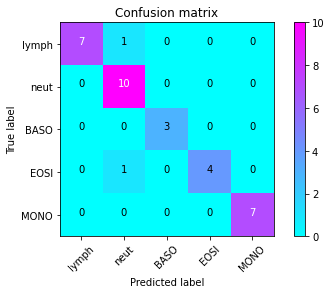

In [106]:
############################## plot the confusion matrix ##########################################
import itertools

from sklearn.metrics import plot_confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.cool):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    # Predict the values from the validation dataset
Y_pred = model.predict(X_test)

confusion_mtx = confusion_matrix(y_test.argmax(axis=1), Y_pred.argmax(axis=1)) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = ["lymph","neut","BASO","EOSI","MONO"])#range(5)


